## Preprocess

In [1]:
from datetime import datetime
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from xgboost import XGBRegressor
import lightgbm as lgbm
import mlflow
from mlflow.models.signature import infer_signature


In [2]:
df = pd.read_csv('../airflow/dags/data/resale_flats_transformed.csv')

/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_26218/292211018.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../airflow/dags/data/resale_flats_transformed.csv')


In [3]:
df.head()

,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,street_name_with_block,postal,x,y,lat,lon,district
0,173917,3,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,01 TO 03,45.0,Improved,1986,60 years 11 months,300000.0,2024,172 ANG MO KIO AVE 4,560172,28349.920537,39632.219604,1.374694,103.836463,20.0
1,173918,3,ANG MO KIO,3 ROOM,308B,ANG MO KIO AVE 1,10 TO 12,70.0,Model A,2012,87 years 07 months,598000.0,2024,308B ANG MO KIO AVE 1,562308,29248.594650,38589.712063,1.365266,103.844538,20.0
2,173919,3,ANG MO KIO,3 ROOM,321,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1977,52 years 02 months,415000.0,2024,321 ANG MO KIO AVE 1,560321,29712.235084,38575.906775,1.365141,103.848704,20.0
3,173920,3,ANG MO KIO,3 ROOM,307C,ANG MO KIO AVE 1,10 TO 12,70.0,Model A,2012,87 years 07 months,601888.0,2024,307C ANG MO KIO AVE 1,563307,29318.866042,38622.316735,1.365561,103.845169,20.0
4,173921,3,ANG MO KIO,3 ROOM,549,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1981,55 years 11 months,380000.0,2024,549 ANG MO KIO AVE 10,560549,30681.283561,39463.114437,1.373165,103.857412,20.0


In [4]:
df.drop(['_id', 'town', 'street_name', 'street_name_with_block', 'postal', 'x', 'y', 'block', 'lease_commence_date'], axis=1, inplace=True)

In [5]:
def convert_remaining_lease(x):
    # example: "60 years 11 months"
    try:
        years = int(x.split(' ')[0])
        months = int(x.split(' ')[2])
    except IndexError:
        # print(x)
        return years * 12
    total_months = years * 12 + months
    return total_months

df['remaining_lease'] = df['remaining_lease'].apply(convert_remaining_lease)

In [6]:
def convert_date(x):
    return datetime(x['year'], x['month'], 1)

df['sale_date'] = df[['year', 'month']].apply(convert_date, axis=1)

In [7]:
categorical_vars = ['flat_type', 'storey_range', 'flat_model', 'district', 'month']
df = pd.get_dummies(df, columns=categorical_vars)

## Merge with cpi and sibor

In [8]:
# merge with cpi, sibor sora
cpi = pd.read_csv('../airflow/dags/data/cpi_with_lag_sma_ema.csv')
sibor = pd.read_csv('../airflow/dags/data/sibor_sora.csv')

In [9]:
sibor['SIBOR DATE'] = pd.to_datetime(sibor['SIBOR DATE'])
sibor.head()

/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_26218/2028583091.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sibor['SIBOR DATE'] = pd.to_datetime(sibor['SIBOR DATE'])


,SIBOR DATE,SIBOR 1M,SIBOR 3M,SIBOR 6M,SIBOR 12M,SOR ON,SOR 1M,SOR 3M,SOR 6M
0,2014-02-01,0.35369,0.40267,0.48191,0.59728,0.04964,0.15485,0.22406,0.28566
1,2014-03-01,0.35057,0.40267,0.48191,0.59728,0.06086,0.14516,0.21618,0.28373
2,2014-06-01,0.35520,0.40361,0.48191,0.59728,0.00742,0.15168,0.21708,0.28373
3,2014-07-01,0.35520,0.40361,0.48191,0.59728,-0.02376,0.14648,0.21829,0.28740
4,2014-08-01,0.35520,0.40461,0.48191,0.59728,-0.01223,0.14648,0.21980,0.28823


In [10]:
cpi['Month'] = pd.to_datetime(cpi['Month'])
cpi.head()

,Month,Value,cpi_lag1,cpi_lag3,cpi_lag6,cpi_lag12,cpi_sma3,cpi_sma6,cpi_sma12,cpi_ema3,cpi_ema6,cpi_ema12
0,1961-01-01,24.542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.542000,24.542000,24.542000
1,1961-02-01,24.565,24.542,NaN,NaN,NaN,NaN,NaN,NaN,24.553500,24.548571,24.545538
2,1961-03-01,24.585,24.565,24.542,NaN,NaN,24.564000,NaN,NaN,24.569250,24.558980,24.551609
3,1961-04-01,24.187,24.585,24.565,24.542,NaN,24.445667,NaN,NaN,24.378125,24.452700,24.495516
4,1961-05-01,24.053,24.187,24.585,24.565,NaN,24.275000,NaN,NaN,24.215563,24.338500,24.427436


In [11]:
# merge with df
df = df.merge(cpi, left_on='sale_date', right_on='Month', how='left')
df.drop('Month', axis=1, inplace=True)
df = df.merge(sibor, left_on='sale_date', right_on='SIBOR DATE', how='left')

# rename Value to cpi   
df.rename(columns={'Value': 'cpi'}, inplace=True)

df.drop('SIBOR DATE', axis=1, inplace=True)

In [12]:
# filter columns with dtype float64 or int64
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(num_cols)
to_remove = ['lat', 'lon', 'resale_price']
num_cols = [col for col in num_cols if col not in to_remove]
num_cols

Index(['floor_area_sqm', 'remaining_lease', 'resale_price', 'year', 'lat',
       'lon', 'cpi', 'cpi_lag1', 'cpi_lag3', 'cpi_lag6', 'cpi_lag12',
       'cpi_sma3', 'cpi_sma6', 'cpi_sma12', 'cpi_ema3', 'cpi_ema6',
       'cpi_ema12', 'SIBOR 1M', 'SIBOR 3M', 'SIBOR 6M', 'SIBOR 12M', 'SOR ON',
       'SOR 1M', 'SOR 3M', 'SOR 6M'],
      dtype='object')


['floor_area_sqm',
 'remaining_lease',
 'year',
 'cpi',
 'cpi_lag1',
 'cpi_lag3',
 'cpi_lag6',
 'cpi_lag12',
 'cpi_sma3',
 'cpi_sma6',
 'cpi_sma12',
 'cpi_ema3',
 'cpi_ema6',
 'cpi_ema12',
 'SIBOR 1M',
 'SIBOR 3M',
 'SIBOR 6M',
 'SIBOR 12M',
 'SOR ON',
 'SOR 1M',
 'SOR 3M',
 'SOR 6M']

## Train Test Split

In [13]:
train_split = df[df['sale_date'] < datetime(2023, 1, 1)]
test_split = df[df['sale_date'] >= datetime(2023, 1, 1)]

testing_dates = test_split['sale_date']

print(train_split.shape)
print(test_split.shape)


(143396, 107)
(32445, 107)


## Scaling

In [14]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit the feature scaler on training data
feature_scaler = feature_scaler.fit(train_split[num_cols])

# Fit the target scaler on training data target values
target_scaler = target_scaler.fit(train_split[['resale_price']])

# Save the scalers
joblib.dump(feature_scaler, 'feature_scaler.save')
joblib.dump(target_scaler, 'target_scaler.save')

# Copy the splits to scale
train_split_scaled = train_split.copy()
test_split_scaled = test_split.copy()

# Transform the features
train_split_scaled[num_cols] = feature_scaler.transform(train_split[num_cols])
test_split_scaled[num_cols] = feature_scaler.transform(test_split[num_cols])

# Transform the target
train_split_scaled['resale_price'] = target_scaler.transform(train_split[['resale_price']])
test_split_scaled['resale_price'] = target_scaler.transform(test_split[['resale_price']])


In [15]:
X_train, y_train = train_split_scaled.drop(['resale_price'], axis=1), train_split_scaled['resale_price']
X_test, y_test = test_split_scaled.drop(['resale_price'], axis=1), test_split_scaled['resale_price']

X_train.drop('sale_date', axis=1, inplace=True)
X_test.drop('sale_date', axis=1, inplace=True)

In [16]:
# print input cols
pprint(X_train.columns.tolist())

['floor_area_sqm',
 'remaining_lease',
 'year',
 'lat',
 'lon',
 'flat_type_1 ROOM',
 'flat_type_2 ROOM',
 'flat_type_3 ROOM',
 'flat_type_4 ROOM',
 'flat_type_5 ROOM',
 'flat_type_EXECUTIVE',
 'flat_type_MULTI-GENERATION',
 'storey_range_01 TO 03',
 'storey_range_04 TO 06',
 'storey_range_07 TO 09',
 'storey_range_10 TO 12',
 'storey_range_13 TO 15',
 'storey_range_16 TO 18',
 'storey_range_19 TO 21',
 'storey_range_22 TO 24',
 'storey_range_25 TO 27',
 'storey_range_28 TO 30',
 'storey_range_31 TO 33',
 'storey_range_34 TO 36',
 'storey_range_37 TO 39',
 'storey_range_40 TO 42',
 'storey_range_43 TO 45',
 'storey_range_46 TO 48',
 'storey_range_49 TO 51',
 'flat_model_2-room',
 'flat_model_3Gen',
 'flat_model_Adjoined flat',
 'flat_model_Apartment',
 'flat_model_DBSS',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation',
 'flat_model_New Gen

## Train with MLFlow

```bash
pip install mlflow
```

Run the MLFlow server on ur terminal

```bash
mlflow server --host 127.0.0.1 --port 8000

In [17]:
mlflow.set_tracking_uri('http://localhost:8000')
signature = infer_signature(X_train, X_test)

In [18]:
# helpers
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
    # Create a DataFrame with dates, actual and predicted values
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction})
    # inverse transfrom the target values
    df_test['actual'] = target_scaler.inverse_transform(df_test[['actual']])
    df_test['prediction'] = target_scaler.inverse_transform(df_test[['prediction']])
    # Convert 'date' to datetime format to ensure proper grouping
    df_test['date'] = pd.to_datetime(df_test['date'])
    # Set 'date' as the index
    df_test.set_index('date', inplace=True)
    # Resample the data by month, taking the mean for each month
    df_test_monthly = df_test.resample('M').mean()
    # Reset index to make 'date' a column again
    df_test_monthly.reset_index(inplace=True)
    # Plotting
    figure, ax = plt.subplots(figsize=(10, 5))
    df_test_monthly.plot(ax=ax, label="Actual", x="date", y="actual", marker='o')
    df_test_monthly.plot(ax=ax, label="Prediction", x="date", y="prediction", marker='x')
    plt.legend(["Actual", "Prediction"])
    plt.title("Monthly Average Resale Price: Actual vs Prediction")
    plt.xlabel("Date")
    plt.ylabel("Resale Price")
    plt.grid(True)
    plt.show()

/Users/ivankoh/miniconda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivankoh/miniconda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'XGBoostResalePricePrediction' already exists. Creating a new version of this model...
2024/03/29 23:37:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostResalePricePrediction, version 4
Created version '4' o

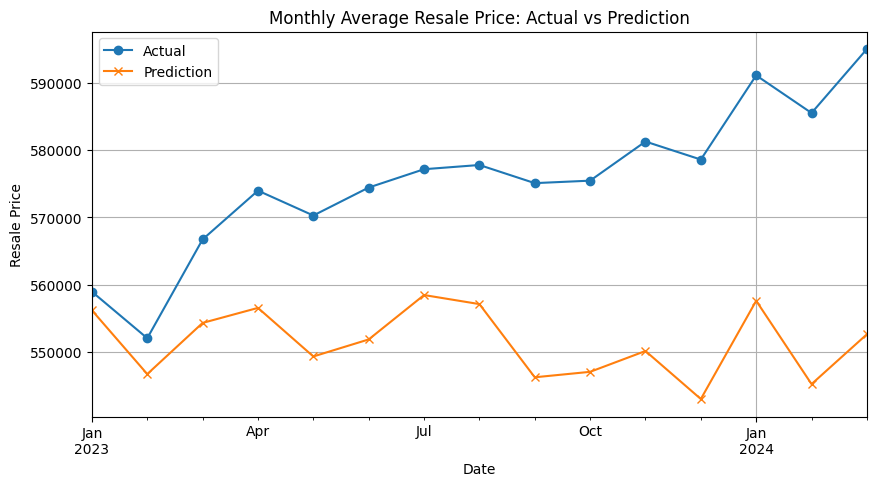

MAE: 0.19630337104889625
MSE: 0.07085355839569242
MAPE: 0.7824820738738789


In [19]:
with mlflow.start_run():
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    
    # Log model parameters manually
    mlflow.log_param("objective", "reg:squarederror")
    mlflow.log_param("n_estimators", 1000)
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Log metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAPE", mape)
    
    # Tag the run for easy retrieval
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("feature", "Resale Price Prediction")
    
    # Log the model
    mlflow.sklearn.log_model(xgb, "model")
    
    # Register the model in the MLflow Model Registry
    mlflow.sklearn.log_model(xgb, "model", registered_model_name="XGBoostResalePricePrediction", signature=signature)
    
    # Plot predictions
    plot_predictions(testing_dates, y_test, y_pred)
    evaluate_model(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 143396, number of used features: 101
[LightGBM] [Info] Start training from score -0.000000


/Users/ivankoh/miniconda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivankoh/miniconda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'LightGBMResalePricePrediction' already exists. Creating a new version of this model...
2024/03/29 23:37:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBMResalePricePrediction, version 3
Created version '3'

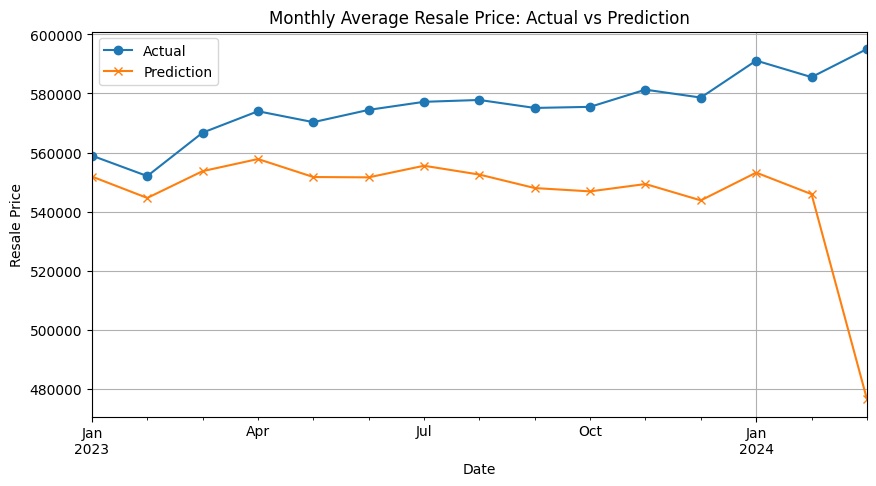

MAE: 0.25077306434017477
MSE: 0.1313070051825276
MAPE: 0.8338018959139062


In [20]:
with mlflow.start_run():
    lgb_model = lgbm.LGBMRegressor()
    
    # Log model parameters manually. For dynamic parameters, you can use lgb_model.get_params()
    for param, value in lgb_model.get_params().items():
        mlflow.log_param(param, value)
    
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Log metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAPE", mape)
    
    # Tag the run for easy retrieval
    mlflow.set_tag("model", "LightGBM")
    mlflow.set_tag("feature", "Resale Price Prediction")
    
    # Log the model
    mlflow.sklearn.log_model(lgb_model, "model")
    
    # Register the model in the MLflow Model Registry
    mlflow.sklearn.log_model(lgb_model, "model", registered_model_name="LightGBMResalePricePrediction", signature=signature)
    
    # Plot predictions
    plot_predictions(testing_dates, y_test, y_pred)
    evaluate_model(y_test, y_pred)

<font color="yellow">
In conclusion, XGBoost is the best model!
</font>

## Deployment 

In [7]:
run_id = "7eba7d2fd2ae4f019ce155ba1338b95b" # replace with your run_id

# takes quite a while to build the docker image
mlflow.models.build_docker(
    # model_uri=f"runs:/{run_id}/model",
    model_uri="mlartifacts/0/7eba7d2fd2ae4f019ce155ba1338b95b/artifacts/model",
    name="resale_price_prediction_xgboost",
    enable_mlserver=True,
)

# then run the model_servce.sh script with the following command
# source ./model_service.sh 

2024/04/05 21:48:26 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/04/05 21:48:26 INFO mlflow.pyfunc.backend: Building docker image with name resale_price_prediction_xgboost
#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 1.06kB done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.9.18-slim
#2 DONE 1.3s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [1/8] FROM docker.io/library/python:3.9.18-slim@sha256:aa7b73608abcfb021247bbb4c111435234a0459298a6da610681097a54ca2c2a
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 4.56MB 0.1s done
#5 DONE 0.1s

#6 [3/8] WORKDIR /opt/mlflow
#6 CACHED

#7 [5/8] COPY model_dir/model /opt/ml/model
#7 CACHED

#8 [4/8] RUN pip install mlflow==2.11.3
#8 CACHED

#9 [6/8] RUN python -c "from mlflow.models import container as C; C._insta